# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [186]:
# Taking all imports for processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

# TODO: code and runtime results
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# loading train-data in dataframes
train_identity_df = pd.read_csv("../data/train_identity.csv")
train_transaction_df = pd.read_csv("../data/train_transaction.csv")
global_df = pd.merge(left=train_transaction_df, right=train_identity_df, left_on=["TransactionID"],
                                       right_on="TransactionID", how="left")
# Since Part 1 to 5 would only involve following fields
# TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2
# Loading above necessary fields into base dataframe
# And performing EDA on these data
basic_fields_df = global_df[["TransactionID", "TransactionDT", "TransactionAmt",
                                              "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", 
                                              "addr1", "addr2", "dist1", "dist2", "isFraud", "DeviceType", "DeviceInfo"]]

In [5]:
fraudulent_df = basic_fields_df[basic_fields_df.isFraud == 1]
non_fraudulent_df = basic_fields_df[basic_fields_df.isFraud == 0]
rows_in_fraud = fraudulent_df.shape[0]
rows_in_non_fraud = non_fraudulent_df.shape[0]
total_rows = basic_fields_df.shape[0]
print("Fraudulent instances: {0} | Non Fraudulent instances: {1}".format(str(rows_in_fraud), str(rows_in_non_fraud)))

Fraudulent instances: 20663 | Non Fraudulent instances: 569877


In [6]:
# Cite: https://stackoverflow.com/questions/41681693/pandas-isnull-sum-with-column-headers

### Comparing nulls between fraudulent and non-fraudulent data-set ###

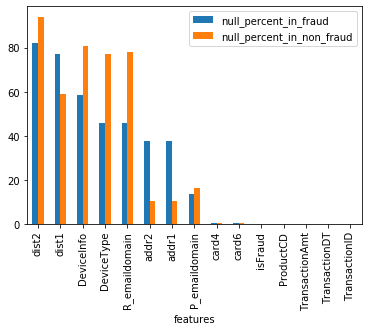

In [338]:
# isnull() returns boolean array for each row
# sum() on isnull() groups null values and take their sum returning a Series
# the Series returned has null value for each column (which can be seen as index for that value in Series)
# In the end, we take transpose() to convert index to column and corresponding row in Series to cell Value for that column
non_fraudulent_null_stats = non_fraudulent_df.isnull().sum().sort_values(ascending=False)
percent_non_fraud_nulls = non_fraudulent_null_stats * 100.0 / rows_in_non_fraud
percent_non_fraud_nulls = percent_non_fraud_nulls.reset_index()
percent_non_fraud_nulls = percent_non_fraud_nulls.rename(columns={'index': 'features', 0: 'null_percent'})

fraudulent_null_stats = fraudulent_df.isnull().sum().sort_values(ascending=False)
percent_fraud_nulls = fraudulent_null_stats * 100.0/ rows_in_fraud
percent_fraud_nulls = percent_fraud_nulls.reset_index()
percent_fraud_nulls = percent_fraud_nulls.rename(columns={'index': 'features', 0: 'null_percent'})

total_null_stats = pd.merge(percent_fraud_nulls, percent_non_fraud_nulls, on='features', suffixes=['_in_fraud', '_in_non_fraud'])

total_null_stats.plot.bar(x='features')

In [259]:
total_null_stats.head(20)

,features,null_percent_in_fraud,null_percent_in_non_fraud
0,dist2,81.943571,94.052050
1,dist1,76.987853,59.023789
2,DeviceInfo,58.345836,80.687236
3,DeviceType,45.743600,77.258426
4,R_emaildomain,45.666167,77.878735
5,addr2,37.463098,10.171493
6,addr1,37.463098,10.171493
7,P_emaildomain,13.502396,16.085225
8,card4,0.198422,0.269532
9,card6,0.188743,0.268830


### Observations ###
1. Just like the non-fraud transactions, majority of null values in fraud transactions are from distances, devices and email addresses.
2. The key difference is in the field of `DeviceInfo` (Windows/Mac OS), `DeviceType` (mobile, desktop), `R_emaildomain` (receipient email).
  
    a. For fraud transaction `null` values for DeviceInfo is around 58% of its set, whereas for non-fraud transactions its around 80%. 
  
    b. For fraud transaction `null` values for DeviceType is around 45% of its set, whereas for non-fraud transaction its around 77%.
  
    c. Also receipent email address are `null` for 45% of its set, whereas for non-fraud transaction its 77%.
  
  ### Conclusion (from visualization around null values in Fraud transactions and Non-Fraud transactions) ###
 One possible explanation for above discrepancy could be: the values for above details like email address are usually not provided or deferred by benevolent transactions, but a fraudster may have provided fake values instead of ignoring like a regular transactor. This in-turn reduced `null` values for fraud transactions.

### Exploring card-issuer field (card4) between fraudulent vs non-fraudluent transactions

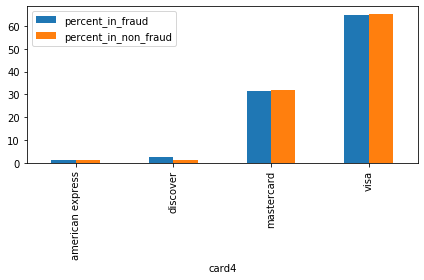

In [363]:
fraud_card_issuer_freq = fraudulent_df.card4.value_counts().sort_values(ascending=True)
fraud_card_issuer_freq = fraud_card_issuer_freq.rename_axis('card4').reset_index(name='freq')

non_fraud_card_issuer_freq = non_fraudulent_df.card4.value_counts().sort_values(ascending=True)
non_fraud_card_issuer_freq = non_fraud_card_issuer_freq.rename_axis('card4').reset_index(name='freq')

total_fraud_card_issuer_freq = fraud_card_issuer_freq.freq.sum()
total_non_fraud_card_issuer_freq = non_fraud_card_issuer_freq.freq.sum()

fraud_card_issuer_freq['percent'] = fraud_card_issuer_freq['freq'] * 100.0 / total_fraud_card_issuer_freq
non_fraud_card_issuer_freq['percent'] = non_fraud_card_issuer_freq['freq'] * 100.0 / total_non_fraud_card_issuer_freq

combined_card_issuer_freq = pd.merge(fraud_card_issuer_freq, non_fraud_card_issuer_freq, on='card4', how='outer', suffixes=['_in_fraud', '_in_non_fraud'])

combined_card_issuer_freq[['card4', 'percent_in_fraud', 'percent_in_non_fraud']].plot.bar(x='card4')
plt.tight_layout()

### Conclusion (card4):
1.  Except for minor bump for card-issuer 'discover' the usage for all types of card-issuers (american express, visa, etc.) is similar between fraudulent vs non-fraudulent transactions
2.  The minor bump in 'discover' category which is 2 % for fraud transactions vs 1 % for non-fraud transactions, may indicate that fraudster are twice as likely to use 'discover' than their non-fraudster counterparts

In [364]:
combined_card_issuer_freq

,card4,freq_in_fraud,percent_in_fraud,freq_in_non_fraud,percent_in_non_fraud
0,american express,239,1.158956,8089,1.423265
1,discover,514,2.492484,6137,1.079809
2,mastercard,6496,31.500339,182721,32.149889
3,visa,13373,64.848220,371394,65.347036


In [350]:
total_non_fraud_card_issuer_freq + total_fraud_card_issuer_freq + 1577

590540

### Exploring card-type values based on card6 fields between fraudulent vs non-fraudulent transactions ###

In [353]:
fraud_card_freq = fraudulent_df.card6.value_counts().sort_values(ascending=True)
fraud_card_freq = fraud_card_freq.rename_axis("card6").reset_index(name="freq")

non_fraud_card_freq = non_fraudulent_df.card6.value_counts().sort_values(ascending=True)
non_fraud_card_freq = non_fraud_card_freq.rename_axis("card6").reset_index(name="freq")

total_non_fraud_freq = non_fraud_card_freq.freq.sum()
total_fraud_freq = fraud_card_freq.freq.sum()

fraud_card_freq['percent'] = fraud_card_freq['freq'] * 100.0 / total_fraud_freq
non_fraud_card_freq['percent'] = non_fraud_card_freq['freq'] * 100.0 / total_non_fraud_freq

combined_card_freq = pd.merge(fraud_card_freq[['card6', 'percent']], non_fraud_card_freq[['card6', 'percent']], on='card6', how='outer', suffixes=["_in_fraud", '_in_non_fraud'])
# Outer join results in NAN for non-existent values in opposite sets, so filling with 0, since we are dealing with percentages
combined_card_freq = combined_card_freq.fillna(0.0) 
combined_card_freq['percent_exp_fraud'] = np.cbrt(combined_card_freq['percent_in_fraud'])
combined_card_freq['percent_exp_non_fraud'] = np.cbrt(combined_card_freq['percent_in_non_fraud'])

combined_card_freq

,card6,percent_in_fraud,percent_in_non_fraud,percent_exp_fraud,percent_exp_non_fraud
0,credit,48.244763,24.463310,3.640408,2.902942
1,debit,51.755237,75.528772,3.726646,4.227051
2,charge card,0.000000,0.002639,0.000000,0.138195
3,debit or credit,0.000000,0.005278,0.000000,0.174115


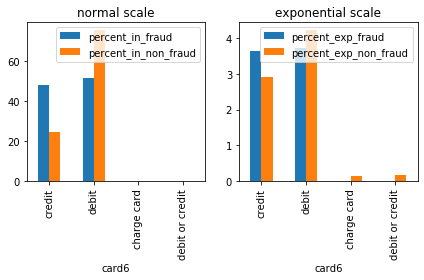

In [334]:
figures, axes = plt.subplots(1,2)
combined_card_freq.plot.bar(x='card6', ax=axes[0], y=['percent_in_fraud', 'percent_in_non_fraud'])
combined_card_freq.plot.bar(x='card6', ax=axes[1], y=['percent_exp_fraud', 'percent_exp_non_fraud'])
axes[0].set_title("normal scale")
axes[1].set_title("exponential scale")
plt.tight_layout()

### Conclusion (card6: card-type) ###
1. Almost twice the proportional times fraud transactions are carried out through credit card than non-fraud transactions (viz., 48%, 24%)
2. Fraudulent transactions are carried out relatively less amount of times through debit card than non-fraud transactions (viz., 51%, 75%)

### Exploring device infos between fraudulent and non-fraudulent transactins ###

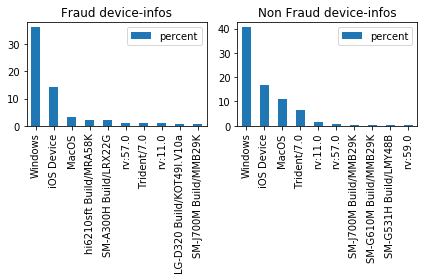

In [162]:
non_null_device_info_count_fraud = fraudulent_df.DeviceInfo.count()
non_null_device_info_count_non_fraud = non_fraudulent_df.DeviceInfo.count()

figure, axes = plt.subplots(1,2)

top_10_fraud_device_counts = fraudulent_df.DeviceInfo.value_counts().to_frame()[0:10]
top_10_fraud_device_counts = top_10_fraud_device_counts.rename(columns={"DeviceInfo": "count"})

top_10_nonfraud_device_counts = non_fraudulent_df.DeviceInfo.value_counts().to_frame()[0:10]
top_10_nonfraud_device_counts = top_10_nonfraud_device_counts.rename(columns={"DeviceInfo": "count"})

# Converting to percentages
# top10FraudDeviceInfos.count = (top10FraudDeviceInfos['count'] * 100) / non_null_device_info_count_fraud
top_10_fraud_device_counts['percent'] = top_10_fraud_device_counts['count'].apply(
    .x: (x * 100)/non_null_device_info_count_fraud)
top_10_nonfraud_device_counts['percent'] = top_10_nonfraud_device_counts['count'].apply(lambda x: (x * 100)/non_null_device_info_count_non_fraud)

top_10_fraud_device_counts.plot.bar(ax=axes[0], y='percent')
top_10_nonfraud_device_counts.plot.bar(ax=axes[1], y='percent')

axes[0].set_title("Fraud device-infos")
axes[1].set_title("Non Fraud device-infos")

plt.tight_layout()

### Exploring DeviceType field between fraudulent vs non-fraudulent transactions ###

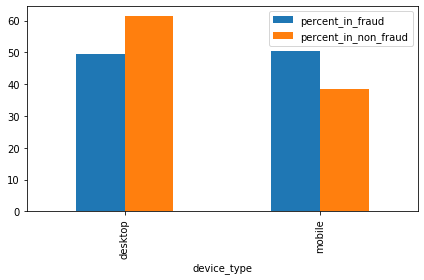

In [378]:
fraud_device_type_freq = fraudulent_df.DeviceType.value_counts().sort_values(ascending=True)
fraud_device_type_freq = fraud_device_type_freq.rename_axis('device_type').reset_index(name='freq')

non_fraud_device_type_freq = non_fraudulent_df.DeviceType.value_counts().sort_values(ascending=True)
non_fraud_device_type_freq = non_fraud_device_type_freq.rename_axis('device_type').reset_index(name='freq')

total_fraud_device_type = fraud_device_type_freq.freq.sum()
total_non_fraud_device_type = non_fraud_device_type_freq.freq.sum()

fraud_device_type_freq['percent'] = fraud_device_type_freq['freq'] * 100.0 / total_fraud_device_type
non_fraud_device_type_freq['percent'] = non_fraud_device_type_freq['freq'] * 100.0 / total_non_fraud_device_type

combined_device_type = pd.merge(fraud_device_type_freq, non_fraud_device_type_freq, on='device_type', how='outer', suffixes=['_in_fraud', '_in_non_fraud'])

combined_device_type[['device_type', 'percent_in_fraud', 'percent_in_non_fraud']].plot.bar(x='device_type')
plt.tight_layout()

### Conclusion (DeviceType): ###
1. Desktop devices are used less in fraudulent transactions, while mobile devices are used heavily for fraudulent transactions


### Exploring DeviceInfo field between fraudulent vs non-fraudulent transacstions ###

Percentage for agent: hi6210sft Build/MRA58K, fraud: 2.091, non-fraud: 0.009
Percentage for agent: SM-A300H Build/LRX22G, fraud: 1.964, non-fraud: 0.031
Percentage for agent: LG-D320 Build/KOT49I.V10a, fraud: 0.709, non-fraud: 0.009


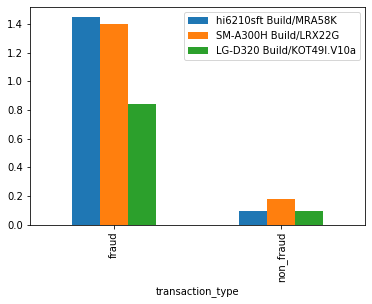

In [185]:
suspicious_device_agents = ['hi6210sft Build/MRA58K', 'SM-A300H Build/LRX22G', 'LG-D320 Build/KOT49I.V10a']
percents_in_innocent_transaction = [non_fraudulent_df[non_fraudulent_df.DeviceInfo == a].shape[0] for a in suspicious_device_agents]
percents_in_innocent_transaction = [p * 100.0 / non_null_device_info_count_non_fraud  for p in percents_in_innocent_transaction]
percents_in_innocent_transaction = [round(p, 3) for p in percents_in_innocent_transaction]

percents_in_fraud_transaction = [fraudulent_df[fraudulent_df.DeviceInfo == a].shape[0] for a in suspicious_device_agents]
percents_in_fraud_transaction = [p * 100.0 / non_null_device_info_count_fraud  for p in percents_in_fraud_transaction]
percents_in_fraud_transaction = [round(p, 3) for p in percents_in_fraud_transaction]

i = 0
df_dic = {}
df_dic['transaction_type'] = ['fraud', 'non_fraud']
for agent in suspicious_device_agents:
    df_dic[agent] = [percents_in_fraud_transaction[i], percents_in_innocent_transaction[i]]
    print("Percentage for agent: " + agent +
          ", fraud: " + str(percents_in_fraud_transaction[i]) + ", non-fraud: " + str(percents_in_innocent_transaction[i]))
    i += 1
suspicious_device_infos = pd.DataFrame(df_dic)


for agent in suspicious_device_agents:
#   Amplifying values to understand the relative scale
    suspicious_device_infos[agent] = np.sqrt(suspicious_device_infos[agent])
suspicious_device_infos.plot.bar(x='transaction_type')

### Conclusion (DeviceInfo): ###
1.  We can observe that for both fraudulent and non-fraudulent transactions, device agents: Windows/iOS/MacOS have been used most frequently
2.  But, for some special devices ('hi6210sft Build/MRA58K', 'SM-A300H Build/LRX22G', 'LG-D320 Build/KOT49I.V10a') have frequency in the range of [0.7, 2] % which may not seem significant at first glance. But it is at least 70~ times more frequent than their non fraudulent counterparts [0.009, 0.031] %
3.  A quick search on this agents reveals that these are agents of mobile devices.
4.  In summary, it seems that fraudulent transactions are done more on mobile devices

### Exploring values of addr1 for fraud vs non-fraud transactions ###

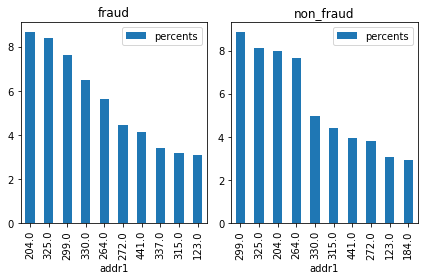

In [393]:
fraud_addr1_freq = fraudulent_df.addr1.value_counts().sort_values(ascending=False)
fraud_addr1_freq = fraud_addr1_freq.rename_axis('addr1').reset_index(name='freq')
fraud_addr1_freq['percents'] = fraud_addr1_freq['freq'] * 100.0 / fraud_addr1_freq.freq.sum()

non_fraud_addr1_freq = non_fraudulent_df.addr1.value_counts().sort_values(ascending=False)
non_fraud_addr1_freq = non_fraud_addr1_freq.rename_axis('addr1').reset_index(name='freq')
non_fraud_addr1_freq['percents'] = non_fraud_addr1_freq['freq'] * 100.0 / non_fraud_addr1_freq.freq.sum()

fraud_addr1_freq = fraud_addr1_freq[0:10]
non_fraud_addr1_freq = non_fraud_addr1_freq[0:10]

figures, axes = plt.subplots(1, 2)
fraud_addr1_freq[['addr1', 'percents']].plot.bar(x='addr1', y = ['percents'], ax=axes[0])
non_fraud_addr1_freq[['addr1', 'percents']].plot.bar(x='addr1', y = ['percents'], ax=axes[1])

axes[0].set_title('fraud')
axes[1].set_title('non_fraud')

plt.tight_layout()

### Conclusion (addr1): ###
1.  Some codes like 337 are relatively more frequent in fraudulent transactions than in non-fraudulent transactions

### Exploring values of addr2 for fraud vs non-fraud transactions ###

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


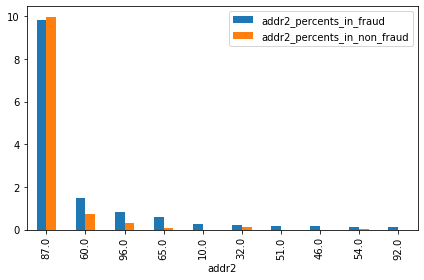

In [380]:
fraud_addr2_freq = fraudulent_df.addr2.value_counts().sort_values(ascending=False)
fraud_addr2_freq = fraud_addr2_freq.rename_axis('addr2').reset_index(name='addr2_counts')
fraud_addr2_freq['addr2_percents'] = fraud_addr2_freq['addr2_counts'] * 100.0 / fraud_addr2_freq.addr2_counts.sum()

non_fraud_addr2_freq = non_fraudulent_df.addr2.value_counts().sort_values(ascending=False)
non_fraud_addr2_freq = non_fraud_addr2_freq.rename_axis('addr2').reset_index(name='addr2_counts')
non_fraud_addr2_freq['addr2_percents'] = non_fraud_addr2_freq['addr2_counts'] * 100.0 / non_fraud_addr2_freq.addr2_counts.sum()

combined_addr2_freq = pd.merge(fraud_addr2_freq, non_fraud_addr2_freq, on='addr2', how='outer', suffixes=['_in_fraud', '_in_non_fraud'])
combined_addr2_freq = combined_addr2_freq.fillna(0)
combined_addr2_freq = combined_addr2_freq[0:10]

addr2_freq_scaled = combined_addr2_freq[['addr2', 'addr2_percents_in_fraud', 'addr2_percents_in_non_fraud']]
addr2_freq_scaled['addr2_percents_in_fraud'] = np.sqrt(addr2_freq_scaled['addr2_percents_in_fraud'])
addr2_freq_scaled['addr2_percents_in_non_fraud'] = np.sqrt(addr2_freq_scaled['addr2_percents_in_non_fraud'])
addr2_freq_scaled.plot.bar(x='addr2', y=['addr2_percents_in_fraud', 'addr2_percents_in_non_fraud'])
plt.tight_layout()

In [311]:
combined_addr2_freq['percent_ratio'] = combined_addr2_freq['addr2_percents_in_fraud'] / combined_addr2_freq['addr2_percents_in_non_fraud']

In [312]:
combined_addr2_freq.head(10)

,addr2,addr2_counts_in_fraud,addr2_percents_in_fraud,addr2_counts_in_non_fraud,addr2_percents_in_non_fraud,percent_ratio
0,87.0,12477.0,96.556261,508004.0,99.236588,0.972991
1,60.0,279.0,2.159108,2805.0,0.547946,3.940369
2,96.0,89.0,0.688748,549.0,0.107245,6.422191
3,65.0,44.0,0.340505,38.0,0.007423,45.870625
4,10.0,8.0,0.061910,0.0,0.000000,inf
5,32.0,6.0,0.046432,85.0,0.016604,2.796391
6,51.0,4.0,0.030955,0.0,0.000000,inf
7,46.0,3.0,0.023216,0.0,0.000000,inf
8,54.0,2.0,0.015477,4.0,0.000781,19.807770
9,92.0,2.0,0.015477,0.0,0.000000,inf


### Conclusion (addr2): ###
1.  Countries with country code: 60, 96, 65, 10, indicate significant transactions in fraud data-set relative to non-fraud data-set
2.  Distribution percentage of above codes [2.1, 0.6, 0.3, 0.06] % in fraud whereas in non-fraud it is [0.5, 0.1, 0, 0]
3.  Though the range of percentage is too small to make major conclusions.
4.  Yet, the corresponding ratio is in order of 3 times, 4 times, 45 times, indefinite times
5.  Example for country code 10.0, all the transactions were fraud and none of the transactions made from country-code 10.0 are non-fraud

### Observing distributions of fields among fraudulent and non-fraudulent transactions ###

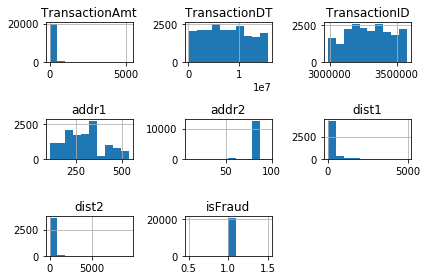

In [12]:
fraud_hists = fraudulent_df.hist()
plt.tight_layout()

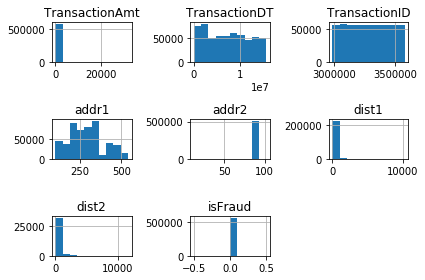

In [13]:
non_fraud_hists = non_fraudulent_df.hist()
plt.tight_layout()

## Conclusion ##
Apart from maximum frequency all histograms depict same kind of spread of values between fraudulent transactions and non-fraudulent transactions. The maximum frequency is different obviously because fraudulent transactions are only small fraction (~ 4%) of the global data-set

In [ ]:
# https://stackoverflow.com/questions/51749208/plotting-two-histograms-from-a-pandas-dataframe-in-one-subplot-using-matplotlib

## Observing max-min-std of the fields among fraud vs non-fraud transactions ##

In [ ]:
fraudulent_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,2.066300e+04,2.066300e+04,20663.000000,12922.000000,12922.000000,4755.000000,3731.000000,20663.0
mean,3.294952e+06,7.690033e+06,149.244779,294.317134,86.286024,174.588854,201.472259,1.0
std,1.620403e+05,4.416551e+06,232.212163,103.584955,4.936238,424.232313,451.589576,0.0
min,2.987203e+06,8.976000e+04,0.292000,110.000000,10.000000,0.000000,0.000000,1.0
25%,3.167366e+06,3.965858e+06,35.044000,204.000000,87.000000,3.000000,7.000000,1.0
50%,3.291934e+06,7.575230e+06,75.000000,299.000000,87.000000,10.000000,49.000000,1.0
75%,3.428646e+06,1.121743e+07,161.000000,330.000000,87.000000,85.500000,233.000000,1.0
max,3.577526e+06,1.581088e+07,5191.000000,536.000000,96.000000,4942.000000,9337.000000,1.0


In [ ]:
non_fraudulent_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,5.698770e+05,5.698770e+05,569877.000000,511912.000000,511912.000000,233514.000000,33896.000000,569877.0
mean,3.281810e+06,7.360791e+06,134.511665,290.643341,86.813620,117.360098,235.199758,0.0
std,1.707548e+05,4.623930e+06,239.395078,101.692564,2.607742,370.641879,536.798492,0.0
min,2.987000e+06,8.640000e+04,0.251000,100.000000,13.000000,0.000000,0.000000,0.0
25%,3.133317e+06,3.010651e+06,43.970000,204.000000,87.000000,3.000000,7.000000,0.0
50%,3.281808e+06,7.271678e+06,68.500000,299.000000,87.000000,8.000000,36.000000,0.0
75%,3.429974e+06,1.125334e+07,120.000000,330.000000,87.000000,24.000000,206.000000,0.0
max,3.577539e+06,1.581113e+07,31937.391000,540.000000,102.000000,10286.000000,11623.000000,0.0


## Conclusion ##


1.   The max value of `TransactionAmt` for fraudulent transactions is 5191, whereas for non-fraudulent transaction it is 31937 (which is roughly 6 times). This suggests that fraudulent transactions are possibly done in smaller denominations may be to avoid flagging or alerting existing Fraud-Detection Systems 
2.   The max value of `dist1` for fraudulent transactions is 4942, whereas for non-fraudulent transaction it is 10286 (which is roughly twice). It suggests that either the fraudster did frauds at smaller distances or  fraudster recorded fake details regarding address or distances in their order details of locations they are aware of (possibly closer to their residences)
3.   The standard deviation of `addr2` of fraudulent transactions is 4.93, whereas for non-fraudulent transactions is 2.6 (which is roughly half). This indicates that the spread of billing region or billing country details for fraudulent transactions is much higher may be because the fraudster were faking their details



## Part 2 - Transaction Frequency

### https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
### https://stackoverflow.com/questions/21441259/pandas-groupby-range-of-values

In [267]:
country_code_freq = basic_fields_df['addr2'].value_counts()
country_code_freq = country_code_freq.rename_axis('country_code').reset_index(name='country_transaction_counts')
country_code_freq.head()

,country_code,country_transaction_counts
0,87.0,520481
1,60.0,3084
2,96.0,638
3,32.0,91
4,65.0,82


### Maximum transaction country ###
We can see in the above step that the country with maximum transactions is the country having country-code, 87 (~ 88% of transactions).
So in the next step we observe the values of country with code 87. 
1. First we will calculate day-level-tags (ith day in the time frame of whole data-set)
2. Then we will calculate hour-level-tags (ith hour in the time frame of whole data-set)
3. Then we will calculate minute-level-tags(ith minute in the time frame of whole day)
4. In the end we will analyse time tag wise distribution for countries with code 87

In [15]:
max_transaction_dt = 16000000 # max value in data-set
transaction_bin_width = 86400  # no. of seconds in a day
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['day_tags'] = row_bin_tags

transaction_bin_width = 3600 # no. of seconds in an hour
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['hour_tags'] = row_bin_tags

transaction_bin_width = 60 # no. of seconds in an minute
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['minute_tags'] = row_bin_tags

# Converting categorical columns to int
categorical_columns = ['day_tags', 'hour_tags', 'minute_tags']
basic_fields_df[categorical_columns] = basic_fields_df[categorical_columns].apply(lambda x: x.cat.codes)
basic_fields_df['day_tags'] = basic_fields_df['day_tags'].astype(np.int64)
basic_fields_df['hour_tags'] = basic_fields_df['hour_tags'].astype(np.int64)
basic_fields_df['minute_tags'] = basic_fields_df['minute_tags'].astype(np.int64)

# Calculating hour of the day (0 to 23) based on hour_tags
basic_fields_df['hour_of_day'] = basic_fields_df['hour_tags'] % 24
basic_fields_df['minute_of_day'] = basic_fields_df['minute_tags'] % 1440

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [16]:
most_frequent_country = basic_fields_df[basic_fields_df.addr2 == 87]

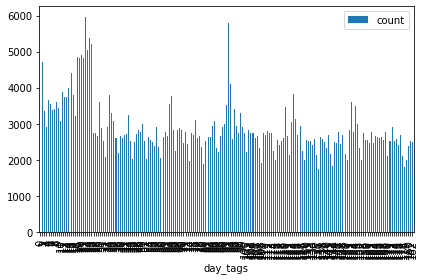

In [17]:
dayWiseTransactionCount = most_frequent_country.groupby("day_tags")["TransactionID"].agg(['count'])
dayWiseTransactionCount.plot.bar()
plt.tight_layout()

## Conclusion ##
As you can see, majority of the transactions were done in the earlier days in the time frame. There are only few outliers (a day or two) in the six month time frame

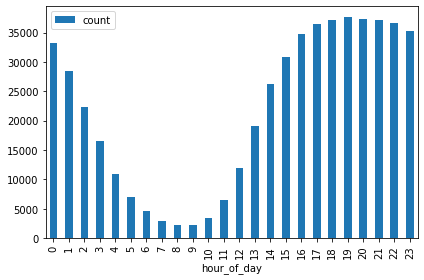

In [18]:
hourWiseTransactionCount = most_frequent_country.groupby("hour_of_day")["TransactionID"].agg(['count'])
hourWiseTransactionCount.plot.bar()
plt.tight_layout()

## Conclusion ##
1. As we can see in the above plot, that a majority of transactions are calculated in hours (hour 0 to hour 2) and in late hours (hour 15 to hour 23).
2. This indicates majority of the people who reside in country with code 87, have their waking hours as per base reference, from hour 0 to hour 4 and hour 13 to hour 23. So waking hours of people in country code 87, lies in ranges [13, 23], [0, 4]

## Part 3 - Product Code

In [20]:
# TODO: code to analyze prices for different product codes
basic_fields_df.ProductCD.value_counts()

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

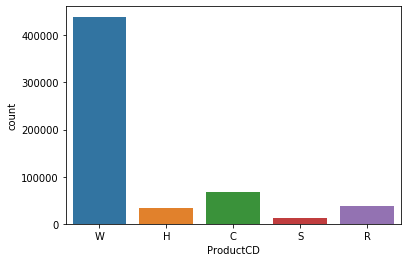

In [260]:
sns.countplot(x='ProductCD', data=basic_fields_df)

In [157]:
product_agg_df = basic_fields_df.groupby(["ProductCD"])["TransactionID", "TransactionAmt"].agg(["min", "max", "count"])
product_agg_df.columns = ["_".join(x) for x in product_agg_df.columns.ravel()] # normalizing hierarchical column names
product_agg_df

,TransactionID_min,TransactionID_max,TransactionID_count,TransactionAmt_min,TransactionAmt_max,TransactionAmt_count
ProductCD,,,,,,
C,2987010,3577534,68519,0.251,712.896,68519
H,2987004,3577506,33024,15.000,500.000,33024
R,2987099,3577531,37699,25.000,1800.000,37699
S,2987038,3577184,11628,5.000,1550.000,11628
W,2987000,3577539,439670,1.000,31937.391,439670


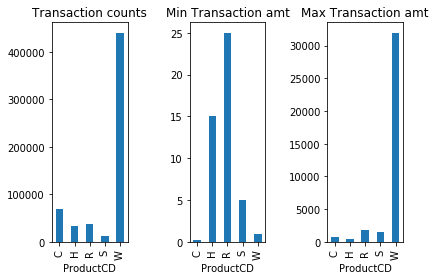

In [ ]:
figure, axes = plt.subplots(1,3)

product_agg_df["TransactionID_count"].plot.bar(ax=axes[0])
product_agg_df["TransactionAmt_min"].plot.bar(ax=axes[1])
product_agg_df["TransactionAmt_max"].plot.bar(ax=axes[2])


axes[0].set_title("Transaction counts")
# axes[0].title.set_size(10)
axes[1].set_title("Min Transaction amt")
# axes[1].title.set_size(10)
axes[2].set_title("Max Transaction amt")
# axes[2].title.set_size(10)
# axes[1].set_title("non_fraud")
# plt.subplot(1,0, 0)

plt.tight_layout()

## Conclusion ##


1.   Product W is the product which is bought the most indicating  it has more demand, thus more price. This is confirmed by the max amount for Product W, which is highest among its peers
2.   Product C has more balance stats. Its' transaction counts are not high yet it's max transaction as well as min transaction amount is lower than its peer. 
3.   Product C is cheapest
4.   Same argument for product W, it's most expensive, it's highly demanded as well as its price is high compared to its peers



Write your answer here

## Part 4 - Correlation Coefficient

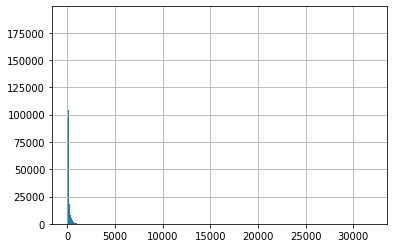

In [22]:
basic_fields_df["TransactionAmt"].hist(bins=1000)

Since, the TransactionAmt is a highly skewed signal, we will use natural logarithm of the field to understand it's nature with other signals 

In [23]:
basic_fields_df["TransactionAmtLog"] = np.log(basic_fields_df["TransactionAmt"])
basic_fields_df["hour_of_day_log"] = np.log(basic_fields_df["hour_of_day"])
basic_fields_df["minute_of_day_log"] = np.log(basic_fields_df["minute_of_day"])

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ip

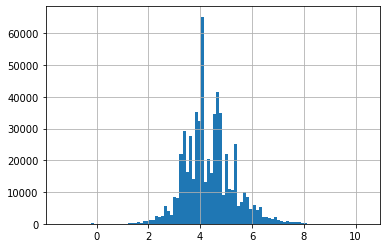

In [24]:
basic_fields_df["TransactionAmtLog"].hist(bins=100)

### Citation ###
https://stats.stackexchange.com/questions/127121/do-logs-modify-the-correlation-between-two-variables

In [25]:
# TODO: code to calculate correlation coefficient
amountVsTime = basic_fields_df[["hour_of_day", "hour_of_day_log", "minute_of_day", "minute_of_day_log", "TransactionAmt", "TransactionAmtLog"]].corr()
amountVsTime

,day_tags,hour_of_day,hour_of_day_log,minute_of_day,minute_of_day_log,TransactionAmt,TransactionAmtLog
day_tags,1.000000,0.005936,0.015907,0.005884,0.010057,0.011656,0.002219
hour_of_day,0.005936,1.000000,0.947394,0.999287,0.900773,0.044526,0.062019
hour_of_day_log,0.015907,0.947394,1.000000,0.946858,0.996571,0.047206,0.067163
minute_of_day,0.005884,0.999287,0.946858,1.000000,0.902921,0.044565,0.062038
minute_of_day_log,0.010057,0.900773,0.996571,0.902921,1.000000,0.039788,0.056623
TransactionAmt,0.011656,0.044526,0.047206,0.044565,0.039788,1.000000,0.701519
TransactionAmtLog,0.002219,0.062019,0.067163,0.062038,0.056623,0.701519,1.000000


In [33]:
basic_fields_df[["hour_of_day", "hour_of_day_log", "minute_of_day", "minute_of_day_log", "TransactionAmt", "TransactionAmtLog"]].corr(method='spearman')

,hour_of_day,hour_of_day_log,minute_of_day,minute_of_day_log,TransactionAmt,TransactionAmtLog
hour_of_day,1.000000,1.000000,0.998190,0.998191,0.038325,0.038325
hour_of_day_log,1.000000,1.000000,0.997953,0.997953,0.034320,0.034320
minute_of_day,0.998190,0.997953,1.000000,1.000000,0.038098,0.038098
minute_of_day_log,0.998191,0.997953,1.000000,1.000000,0.038111,0.038111
TransactionAmt,0.038325,0.034320,0.038098,0.038111,1.000000,1.000000
TransactionAmtLog,0.038325,0.034320,0.038098,0.038111,1.000000,1.000000


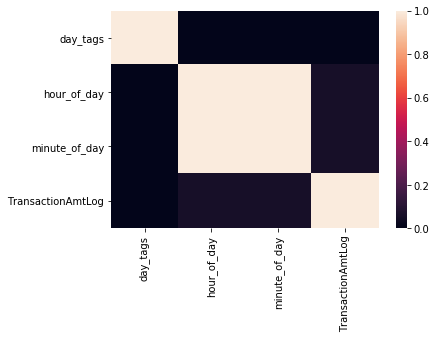

In [20]:
sns.heatmap(amountVsTime)

## Part 5 - Interesting Plot

In [100]:
# TODO: code to generate the plot here.

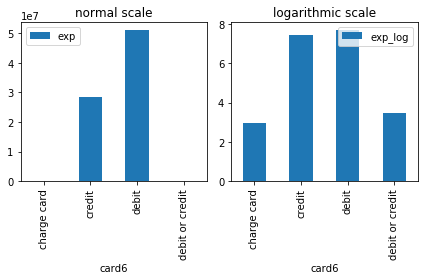

In [320]:
expenses = basic_fields_df.groupby(['card6'])['TransactionAmt'].agg(['sum'])
expenses = expenses.rename(columns={"sum": "exp"})

expenses['exp_log'] = np.log10(expenses['exp'])

figure, axes = plt.subplots(1,2)
expenses.plot.bar(ax=axes[0], y='exp')
expenses.plot.bar(ax=axes[1], y='exp_log')

axes[0].set_title("normal scale")
axes[1].set_title("logarithmic scale")
plt.tight_layout()

# Conclusion (Insight) #
1.  As you can notice that, most expenses are done through debit card followed by credit card. The least expenses are done through charge card
2.  This indicates that people prefer to stay under their credit limit, else they will have to penalty interest rates. Possibly fear of penalty drive people to use less or avoid using credit card for major expenses. This reveals risk-averse nature of people
3.  Also, the minimal expenses on charge card compared to credit card indicate that people are ready to face interest rates of credit card for late payment but are not ready to face heavy late penalty fees on charge card. A simple search in the domain card types highlights that late penalty feese on charge card are in higher order than on interest on credit card

In [188]:
b = basic_fields_df.groupby(['addr2', 'card6'])['TransactionID'].agg(['count'])
b = b.unstack(level=-1)
b.head()

count                             
card6 charge card credit debit debit or credit
addr2                                         
10.0          NaN    7.0   1.0             NaN
13.0          NaN    5.0   2.0             NaN
14.0          NaN    1.0   NaN             NaN
15.0          NaN    1.0   NaN             NaN
16.0          2.0   46.0   7.0             NaN

In [189]:
basic_fields_df.card6.value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [190]:
basic_fields_df.card4.value_counts()

visa                384767
mastercard          189217
american express      8328
discover              6651
Name: card4, dtype: int64

Write your answer here

## Part 6 - Prediction Model

In [ ]:
# TODO: code for your final model

## Checking Duplicates for the significant fields across whole data-set
Testing whether there are any duplicates in the base data (TransactionID, DeviceType, DeviceInfo, TransactionDT, TransactionAmt, ProductCD, addr1, addr2, dist1, dist2, card4, card6, P_emaildomain, R_emaildomain) of transactions and devices.

---

Found that there are no duplicates since shape on `base_df[base_duplicates]` responds with 0 count against number of rows


In [337]:
base_duplicates = basic_fields_df.duplicated()
print("Number of duplicates in base fields: " + str(basic_fields_df[base_duplicates].shape[0]))

Number of duplicates in base fields: 0


Write your answer here

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: FILL HERE

Highest Rank: FILL HERE

Score: FILL HERE

Number of entries: FILL HERE

INCLUDE IMAGE OF YOUR KAGGLE RANKING